# **Chap3：卷积神经网络**

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt
from source.code import ch3
from source.code import utils

In [ ]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=12)

## **3.3 现代卷积神经网络**

### **3.3.1 深度卷积神经网络AlexNet**

在 LeNet 提出后，CNN 在计算机视觉和机器学习领域中很有名气。但 CNN 并没有主导这些领域，因为虽然 LeNet 在小数据集上取得了很好的效果，但是在**更大、更真实的数据集上训练 CNN 的性能和可行性还有待研究**，**在上世纪 90 年代初到 2012 年之间的大部分时间里，神经网络往往被其他机器学习方法超越，如支持向量机 SVM**

事实上，将神经网络与其他机器学习算法相对比不太合适，神经网络给出了一种**端对端**（**end-to-end**）的训练方法，即神经网络的建模可以从原始输入（例如像素）直接得到最终想要的输出（例如分类结果），而经典机器学习的建模过程大概为：
* 获取一个有趣的数据集
* 根据领域知识（光学、几何学、其他知识）以及偶然的发现，手工对特征数据集进行预处理
* **通过标准的特征提取算法**，如SIFT（尺度不变特征变换），SURF（加速鲁棒特征）或其他手动调整的方法处理原始输入，加工得到特征
* 将提取的特征送入合适的分类器中（如SVM，决策树）

基于此，人们给出了**特征图**（**Feature Map**）的概念：
* 在各种复杂的输入数据中（尤其是图像，语言等**非结构化数据**），数据的**信噪比较低**，一些有助于模型识别的**关键信息容易淹没在噪声中**，或者需要**将多个不同的特征交叉融合（即非线性表征）才能加工得到有用的信号**
* 这些真正对机器学习模型有效的，被加工处理得到的特征统一称为**特征图**
* 一些研究人员，致力于**根据具体的领域知识**，针对具体问题提出各种特征提取算法，以构造优秀的特征图
* 而深度学习领域研究者认为，**特征图的构造本身应该被学习**，在合理地复杂性前提下，特征应该由多个共同学习的神经网络层组成，每个层都有可学习的参数，这就是**深度学习的核心思想**
* 事实上，**当给定相同的特征图时，无论是继续使用神经网络还是换做其他传统机器学习模型，所取得的结果会很接近**

因此，深度学习模型的两大优势是：
* 几乎所有模型都可以设计为**端对端的模型**
* 通过多层复杂的非线性变换，并附加大量的可训练参数，让**深度学习模型能非常有效地提取特征图**

因此，一个**成功的深度神经网络，应该设计足够优秀的网络结构，以提升其特征图的提取能力**

2012年，**AlexNet**横空出世。它首次证明了学习到的特征可以超越手工设计的特征，它一举打破了计算机视觉研究的现状，AlexNet使用了8层卷积神经网络，并以很大的优势赢得了2012年ImageNet图像识别挑战赛

<img src="./source/Chap3/AlexNet结构.svg" width=400>

AlexNet和LeNet的设计理念非常相似，但也存在显著差异：
* **AlexNet比相对较小的LeNet5要深得多**，AlexNet由八层组成：5个卷积层、2个全连接隐藏层和一个全连接输出层
* **AlexNet使用ReLU**而不是sigmoid作为其激活函数

**AlexNet在第一层使用了比 LeNet 大很多的** $11\times 11$ **卷积核**，这是因为 ImageNet 竞赛的图像输入尺寸是 $224\times 224$，因此需要更大的卷积核来提取局部特征，这里涉及到网络结构设计的问题：
* 卷积核提取的是局部特征，因此需要根据具体问题来设计卷积核的大小
  * 例如**关键信息在整张图上的占比很小，就应该选用规模较小的卷积核**，反之同理

AlextNet是在ImageNet数据集上训练的，由于该数据集太大，我们这里演示的是`CIFAR-100`数据集，`CIFAR-100`数据集每张图像的大小是 $32\times 32\times 3$，这有别于 $224\times 224\times 3$，不过我们可以借助`Tensorflow`提供的数据预处理接口，**将图像放大为 $224\times 224$ 像素**：
* **通常来讲这不是一个明智的做法**，但在这里这样做是为了有效使用AlexNet架构，实践中应该根据输入图像的像素设计合适的卷积神经网络，如果为了使用某个成熟的模型而需要缩小 / 放大图像，**放大和缩小的比例也不应该差异过大**
* `Tensorflow`还提供了非常多的数据预处理方法，例如**随机裁剪，调整颜色，随机调整图像旋转角度，随机改变亮度，图像翻转等**，这些内容我们将在**数据增强**部分介绍

In [4]:
# 定义一个改变图像大小的层
ImageResize = tf.keras.layers.experimental.preprocessing.Resizing(height=224,width=224)

In [5]:
# 导入 CIFAR-100 数据集
(x_train, y_train), (x_test, y_test) = ch3.load_cifar100()
# 变换输入图像的大小
ImageResize(x_train[0:5]).shape

TensorShape([5, 224, 224, 3])

接下来，我们可以定义`AlexNet`

In [6]:
def AlexNet(input_shape : tuple, num_class : int):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.experimental.preprocessing.Resizing(height=224,width=224),
        # 第一块卷积 + 汇聚层
        tf.keras.layers.Conv2D(96,kernel_size=11,strides=4,activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=3,strides=2),
        # 第二块卷积 + 汇聚层
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # 连续三个卷积层 + 汇聚层，通道数减少
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # 拉直，送入全连接层
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_class),
        tf.keras.layers.Softmax()
    ])

我们可以创建模型，观察每一层处理后，特征维度的变化情况

In [9]:
model = AlexNet(input_shape=(32,32,3),num_class=100)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 384)      

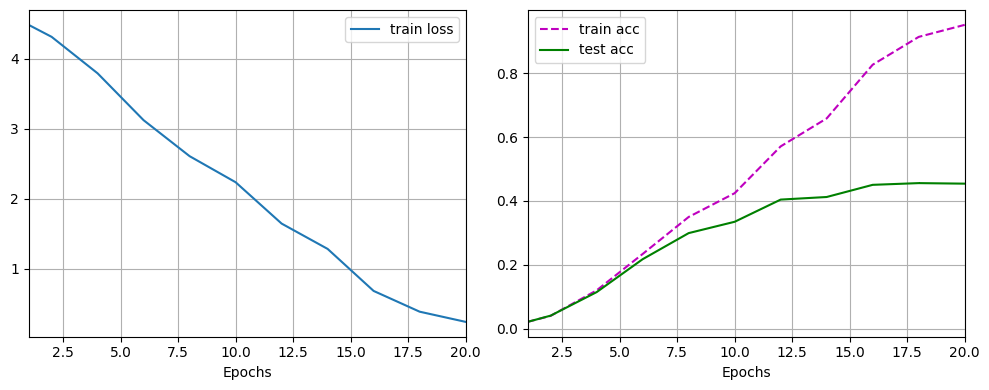

In [10]:
# 进行训练
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=20,verbose=2,lr=0.1)

`AlexNet`在训练集上已经可以做到接近90%的正确率，在测试集上取得50%的正确率：
* 模型的学习能力确实增强了，在测试集上的正确率大幅提升
* 同时观察到**模型出现了比较严重的过拟合**

### **3.3.2 块状网络VGGNet**

虽然AlexNet证明深层神经网络卓有成效，但它没有提供一个通用的模板来指导后续的研究人员设计新的网络，从VGGNet开始，神经网络架构的设计也逐渐变得更加整体和抽象，**研究人员开始从单个神经元的角度思考问题，发展到层，块，重复层的模式**，使用块的想法首先出现在牛津大学的VGG网络中

经典卷积神经网络的基本组成部分是下面的这个序列：
* 带填充以保持分辨率的卷积层
* 非线性激活函数，如ReLU
* 汇聚层，如最大汇聚层

一个**VGG块**与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层

VGG使用了 $3\times 3$ 的卷积核，填充为1（保持高宽不变），然后使用 $2\times 2$ 的汇聚窗口，步幅为2（进行分辨率减半的下采样）

In [2]:
# 创建 VGG 块儿
def vgg_block(num_convs : int, num_channels : int):
    block = tf.keras.models.Sequential()
    # 添加多个卷积层
    for _ in range(num_convs):
        block.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,padding="same",activation="relu"))
    # 添加汇聚层
    block.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
    return block

`AlexNet`和`VGGNet`的网络结构对比如如下所示

<img src="./source/Chap3/VGGNet结构.svg" width=700>

VGG神经网络连接几个`VGG块`（在`vgg_block`函数中定义），其中可以指定每个VGG块里卷积层个数和输出通道数。全连接模块则与AlexNet中的相同：
* 原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层
* 第一个块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512

In [3]:
conv_arch= ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [4]:
def VGGNet(conv_arch : tuple, input_shape : tuple, num_class : int):
    """
    conv_arch : tuple
        VGGNet 卷积块的结构
    """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(input_shape))
    model.add(tf.keras.layers.experimental.preprocessing.Resizing(height=224,width=224))
    # 添加 VGG 块
    for (num_convs, num_channels) in conv_arch:
        model.add(vgg_block(num_convs,num_channels))
    # 添加全连接层
    model.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_class),
        tf.keras.layers.Softmax()
    ]))

    return model

接下来，创建模型，查看模型结构

In [5]:
model = VGGNet(conv_arch=conv_arch,input_shape=(32,32,3),num_class=100)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 112, 112, 64)      1792      
                                                                 
 sequential_2 (Sequential)   (None, 56, 56, 128)       73856     
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 256)       885248    
                                                                 
 sequential_4 (Sequential)   (None, 14, 14, 512)       3539968   
                                                                 
 sequential_5 (Sequential)   (None, 7, 7, 512)         4719616   
                                                                 
 sequential_6 (Sequential)   (None, 100)               1

可以看到，`VGGNet`**参数规模已经达到了1.3亿**，并且**绝大部分参数来自于最后的全连接层**

模型训练的演示部分，我们创建一个**迷你版的VGGNet，将通道数量减少4倍，节省训练时间**

In [6]:
# 加载 CIFAR-100 数据集
(x_train,y_train), (x_test,y_test) = ch3.load_cifar100()

训练集特征形状： (50000, 32, 32, 3)
训练集标签形状： (50000, 1)


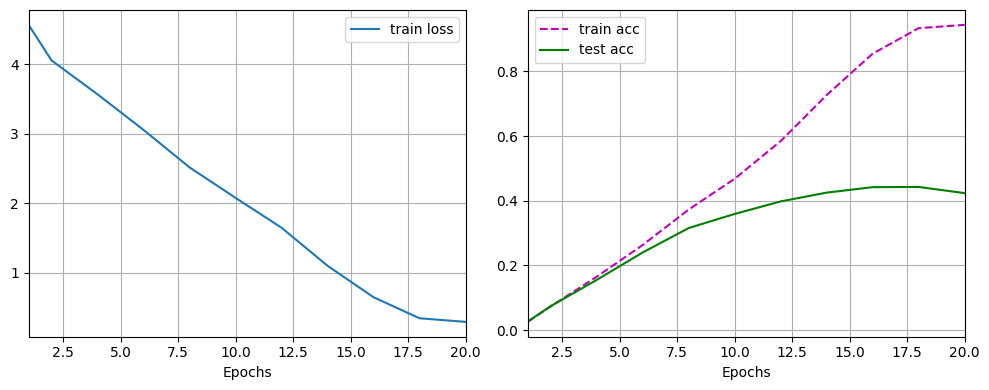

In [7]:
conv_arch= ((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))
model = VGGNet(conv_arch=conv_arch,input_shape=(32,32,3),num_class=100)
# 进行训练
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=20,verbose=2,lr=0.05)

`VGGNet`的训练结果与`AlexNet`相似，模型的学习能力很强，但都出现了严重过拟合

### **3.3.3 网络中的网络NiN**

**AlexNet和VGG对LeNet的改进主要在于如何扩大和加深**卷积层和汇聚层，以更好的提取特征图，而**全连接层负责将卷积层学习得到的所有特征交叉加工**，如果在模型的早期使用全连接层，可能会完全放弃特征表示的空间结构，**NiN提供了一个非常简单的解决方案**，在每个像素的**通道上使用多层感知机**，即前面提到的 $1\times 1$ 卷积核

NiN的网络结构图如下所示：

<img src="./source/Chap3/NiN结构.svg" width=800>

NiN块以一个普通卷积层开始，后面是两个 $1\times 1$ 的卷积层。这两个 $1\times 1$ 卷积层充当带有ReLU激活函数的逐像素全连接层

In [8]:
def nin_block(num_channels, kernel_size, strides, padding):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(num_channels, kernel_size, strides=strides, 
                               padding=padding, activation='relu'),
        # 两个 1x1 卷积
        tf.keras.layers.Conv2D(num_channels,kernel_size=1,activation='relu'),
        tf.keras.layers.Conv2D(num_channels,kernel_size=1,activation='relu')
    ])

NiN使用窗口大小为 $11\times 11$, $5\times 5$, $3\times 3$ 的卷积层，输出通道数量与`AlexNet`相同，每个NiN块后有一个最大汇聚层，汇聚层窗口大小为 $3\times 3$，步幅为 2

**NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层**：
* NiN使用一个**NiN块**，其**输出通道数等于标签类别的数量**。最后放一个**全局平均汇聚层**（**Global Average Pooling**），得到**对数几率Logits**，随后经过Softmax变换就可以得到类别的概率分布了
* NiN如此设计一个优点是，**显著减少了模型所需参数的数量，尤其是最后全连接层的参数数量**。然而，在实践中，这种设计有时会**增加训练模型的时间**

In [11]:
def NiN(input_shape : tuple, num_class : int):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(input_shape),
        tf.keras.layers.experimental.preprocessing.Resizing(width=224,height=224),
        # 第一个 NiN 块
        nin_block(96, kernel_size=11, strides=4, padding='valid'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # 第二个 NiN 块
        nin_block(256, kernel_size=5, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # 第三个 NiN 块
        nin_block(384, kernel_size=3, strides=1, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),

        tf.keras.layers.Dropout(0.5),
        # 最后一个 NiN 块，输出通道数等于类别数量
        # 该层输出的特征形状为 `(batch, width, height, num_class)`
        nin_block(num_class, kernel_size=3, strides=1, padding='same'),

        # 使用全局平均汇聚层，将每个像素的信息进行汇聚
        # 该层输出的特征形状为 `(batch, num_class)`
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Softmax()
    ])

In [17]:
# 创建模型，查看每层输出的形状
model = NiN(input_shape=(32,32,3),num_class=100)
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 sequential_24 (Sequential)  (None, 54, 54, 96)        53568     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 sequential_25 (Sequential)  (None, 26, 26, 256)       746240    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 12, 256)      0         
 g2D)                                                            
                                                                 
 sequential_26 (Sequential)  (None, 12, 12, 384)     

可以看到`NiN`的参数规模很小，**仅有200多万**，下面训练模型，查看模型的学习能力

In [18]:
# 加载 CIFAR-100 数据集
(x_train,y_train), (x_test,y_test) = ch3.load_cifar100()

训练集特征形状： (50000, 32, 32, 3)
训练集标签形状： (50000, 1)


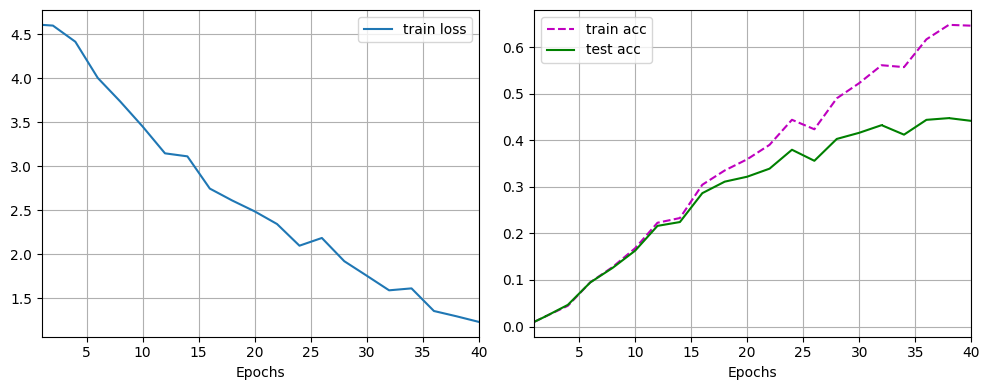

In [19]:
# 进行训练
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=40,verbose=2,lr=0.1)

可以观察到，**参数规模的减小，使得模型不那么容易过拟合了**

### **3.3.4 并行连接网络GoogLeNet**

GoogLeNet吸收了NiN串联网络的思想，同时做出改进，之前人们选择卷积核大小时往往需要在大卷积核和小卷积核之间进行取舍，GoogLeNet的选择是，我全都要，它认为**使用不同大小的卷积核组合有时更有利**

<img src="./source/Chap3/Inception块.svg" width=800>

GoogLeNet中，基本的卷积单元称为`Inception`块，这很可能得名于电影《盗梦空间》（Inception）：
* Inception块**由四条并行路径组成**
* 前三条路径使用窗口大小为 $1\times 1$, $3\times 3$ 和 $5\times 5$ 的卷积核，从不同空间大小中提取信息
* 中间的两条路径在输入上执行 $1\times 1$ 卷积，从而**减少通道数，降低模型复杂度**
* 第四条路径使用 $3\times 3$ 最大汇聚层，然后用 $1\times 1$ 卷积层来改变通道数
* 四条路径都**使用合适的填充来使输入与输出的高和宽一致**
* 最后我们**将每条线路的输出在通道维度上拼接**，并构成Inception块的输出

In [20]:
class Inception(tf.keras.Model):
    def __init__(self, c1, c2, c3, c4, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 第一条路径
        self.path1_1 = tf.keras.layers.Conv2D(c1, kernel_size=1, activation="relu")
        # 第二条路径
        self.path2_1 = tf.keras.layers.Conv2D(c2[0], kernel_size=1, activation="relu")
        self.path2_2 = tf.keras.layers.Conv2D(c2[1], kernel_size=3, padding="same", activation="relu")
        # 第三条路径        
        self.path3_1 = tf.keras.layers.Conv2D(c3[0], kernel_size=1, activation="relu")
        self.path3_2 = tf.keras.layers.Conv2D(c3[1], kernel_size=5, padding="same", activation="relu")
        # 第四条路径
        self.path4_1 = tf.keras.layers.MaxPool2D(pool_size=3,strides=1,padding="same")
        self.path4_2 = tf.keras.layers.Conv2D(c4,kernel_size=1,activation="relu")
        # 拼接算子
        self.concat = tf.keras.layers.Concatenate(axis=-1)
    
    def call(self, inputs, training=None, mask=None):
        path1 = self.path1_1(inputs)
        path2 = self.path2_2(self.path2_1(inputs))
        path3 = self.path3_2(self.path3_1(inputs))
        path4 = self.path4_2(self.path4_1(inputs))
        return self.concat([path1,path2,path3,path4])

**GoogLeNet网络非常有效，它可以用各种卷积核尺寸探索图像**，这意味着不同大小的卷积核窗口可以有效地识别不同范围的图像细节，同时，我们可以为不同的卷积核分配不同数量的参数

下图是`GoogLeNet`的结构示意图，一共包含了9个Inception块:
* 最后同样采用全局平均汇聚层来生成Logits，**避免最后使用全连接层**
* Inception块之间的最大汇聚层可降低维度

<img src="./source/Chap3/GoogLeNet结构.svg" width=250>

下面，我们逐块儿定义`GoogLeNet`

* 第一个模块使用64个通道、$7\times 7$ 的卷积层

In [21]:
def GoogLeNetBlock1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=2, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")
    ])

* 第二个模块使用两个卷积层：第一个卷积层是64个通道、$1\times 1$ 卷积层；第二个卷积层使用将通道数量增加三倍的 $3\times 3$ 卷积层，这对应于Inception块中的第二条路径

In [22]:
def GoogLeNetBlock2():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, 1, activation="relu"),
        tf.keras.layers.Conv2D(192, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same")
    ])

* 第三个模块串联两个完整的Inception块：
  * 第一个Inception块的输出通道数为：$64 + 128 + 32 + 32 = 256$
  * 第二个Inception块的输出通道数为：$128 + 192 + 96 + 64 = 480$

In [23]:
def GoogLeNetBlock3():
    return tf.keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')
    ])

* 第四模块更加复杂， 它串联了5个Inception块
  * 第一个Inception块的输出通道数为：$192 + 208 + 48 + 64 = 512$
  * 第二个Inception块的输出通道数为：$160 + 224 + 64 + 64 = 512$
  * 第三个Inception块的输出通道数为：$128 + 256 + 64 + 64 = 512$
  * 第四个Inception块的输出通道数为：$112 + 288 + 64 + 64 = 528$
  * 第五个Inception块的输出通道数为：$256 + 320 + 128 + 128 = 832$

In [24]:
def GoogLeNetBlock4():
    return tf.keras.models.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])

* 第五模块包含输出通道数为 $256 + 320 + 128 + 128 = 832$ 和 $384 + 384 + 128 + 128 = 1024$ 的两个Inception块，后面紧根据全局平均汇聚层 

In [25]:
def GoogLeNetBlock5():
    return tf.keras.models.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        tf.keras.layers.GlobalAveragePooling2D()
    ])

组合上述的几个模块，就可以得到完整的`GoogLeNet`模型了
* 由于GoogLeNet模型复杂，训练缓慢，我们将图像尺寸更改到 $96\times 96$，得到迷你版GoogLeNet便于演示

In [36]:
def GoogLeNet(input_shape : tuple, num_class : int):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(input_shape),
        tf.keras.layers.experimental.preprocessing.Resizing(width=96,height=96),
        # 顺序5层计算
        GoogLeNetBlock1(),
        GoogLeNetBlock2(),
        GoogLeNetBlock3(),
        GoogLeNetBlock4(),
        GoogLeNetBlock5(),
        # 输出得到概率
        tf.keras.layers.Dense(num_class),
        tf.keras.layers.Softmax()
    ])

In [37]:
# 创建模型
model = GoogLeNet(input_shape=(32,32,3),num_class=100)
model.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_9 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 sequential_53 (Sequential)  (None, 24, 24, 64)        9472      
                                                                 
 sequential_54 (Sequential)  (None, 12, 12, 192)       114944    
                                                                 
 sequential_55 (Sequential)  (None, 6, 6, 480)         552432    
                                                                 
 sequential_56 (Sequential)  (None, 3, 3, 832)         2809168   
                                                                 
 sequential_57 (Sequential)  (None, 1024)              2487536   
                                                                 
 dense_8 (Dense)             (None, 100)             

**GoogLeNet虽然结构复杂，但由于采用了NiN的设计思路，参数规模并不大，仅有600万参数**

In [38]:
# 加载 CIFAR-100 数据集
(x_train,y_train), (x_test,y_test) = ch3.load_cifar100()

训练集特征形状： (50000, 32, 32, 3)
训练集标签形状： (50000, 1)


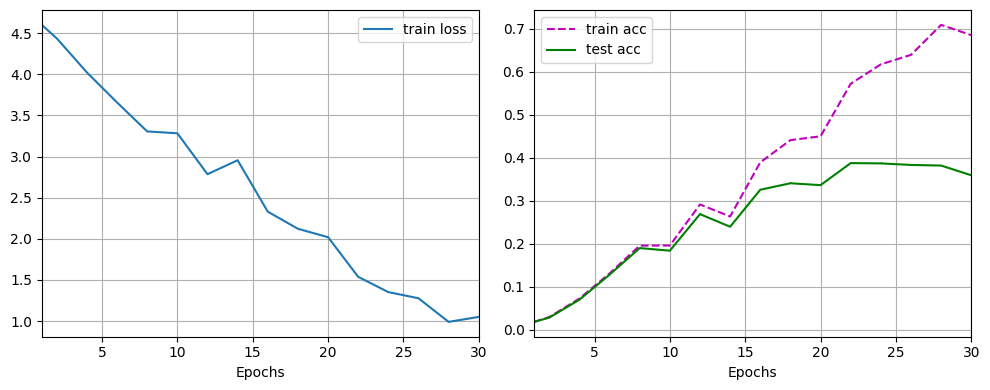

In [39]:
# 进行训练
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=30,verbose=2,lr=0.1)

### **3.3.5 批量归一化BatchNorm和残差网络ResNet**

#### **3.3.5.1 批量归一化**

**训练深层神经网络是十分困难的，特别是在较短的时间内让模型收敛**，**批量归一化**（**batch normalization**）技术的提出，一定程度上解决了该问题，尽管有关该技术的理论研究还不太完善，但BatchNorm在实践中非常有用，再结合在后面将介绍的**残差跳连**，**BatchNorm使得研究人员能够训练100层以上的网络**

回顾训练深度学习模型面临的挑战：
* 从数值稳定性的角度出发，**数据预处理的方式通常会对最终结果产生巨大影响**，使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1，或者标准化到 $[0,1]$ 区间中，这能**保证参数的数量级比较统一**
* 当我们训练时，中间层的变量（例如，多层感知机中的线性变换输出）可能具有**更广的变化范围**，**模型参数随着训练更新变幻莫测**，BatchNorm的提出者非正式地假设，这些**变量分布中的偏移可能会阻碍网络的收敛**
* **更深层的网络很复杂，容易过拟合**，这意味着**正则化**变得更加重要

BatchNorm应用于单个计算层（当然，也可以应用到所有层），基本想法是：
* 在每次训练迭代中，我们首先**归一化输入，即减去其均值并除以其标准差**
* 均值和标准差二者均**基于当前的小批量数据**（批量归一化名称的由来）
* 在此基础上，我们再应用一次**比例系数**和**比例偏移**

从数学表达式来看，BatchNorm层可以表达为：
$$
\text{BN}(x) = \gamma\times \frac{x - \hat{\mu}_B}{\hat{\sigma}_B} + \beta,\quad x\in\mathcal{B}
$$

其中，$x\in\mathcal{B}$ 表示来自小批量 $\mathcal{B}$ 的输入特征，$\hat{\mu}_B$ 是小批量的均值，$\hat{\sigma}_B$ 是小批量的标准差，应用标准化后，输入的批量特征均值为0，方差为1，我们再应用拉伸系数 $\gamma$ 和偏移系数 $\beta$，它们的形状与 $x$ 相同，并且 $\gamma,\beta$ **是与其他模型参数一起学习的参数**，这**去除了我们主观上对输入特征分布的选择**，让分布是可学习的

注意，BatchNorm对批量大小为 1 的小批量是无效的，因为减去均值后，将导致输入变为 0，所以，**只有使用足够大的小批量，BatchNorm这种方法才是有效且稳定的**，在**应用BatchNorm时，批量大小的选择可能比没有BatchNorm时更重要**

在实现时，批量均值和方差计算为：
$$
\hat{\mu}_B = \frac{1}{|\mathcal{B}|} \sum_{x\in \mathcal{B}} x,\quad 
\hat{\sigma}_B = \frac{1}{|\mathcal{B}|} \sum_{x\in \mathcal{B}} (x - \hat{\mu}_B)^2 + \epsilon
$$

其中，方差估计中引入了一个小的常数 $\epsilon > 0$ 防止方差估计为0，导致数值溢出

这里会产生的疑问是，每个批量的数据各不相同，因此均值和方差 $\hat{\mu}_B,\hat{\sigma}_B$ 的估计会包含随机噪声，自然会担忧**这种不稳定的噪声可能会干扰模型学习**：
* 事实上这是有益的，这是深度学习中一个**反复出现的主题**，但尚未在理论上找到明确解释
* 在实践中，**优化中的各种噪声源通常会导致更快的训练和较少的过拟合**（例如**Dropout**，**样本随机采样**）
* 这类变化可以看做是**正则化的一种形式**
* 一些初步研究**将BatchNorm的性质与贝叶斯先验**相关联，这些理论部分揭示了批量大小为 50~100 的中等批量大小最适合BatchNorm

**通常，我们将批量归一化层置于全连接层中的仿射变换和激活函数之间**，可以用下面的式子表示，这样使用BatchNorm能很大程度上解决**部分激活函数的梯度消失问题**：
$$
h = \phi\left( \text{BN}(Wx + b) \right)
$$

对于卷积神经网络，情况稍微复杂一些：
* 相同的是，对于卷积层，我们可以**在卷积层之后和非线性激活函数之前应用批量归一化**
* 当卷积有多个输出通道时，我们需要**对这些通道的“每个”输出执行批量归一化**
  * 每个通道都有自己的拉伸和偏移参数 $\gamma,\beta$
* 假设输入 $X\in\mathbb{R}^{b\times w\times h\times c}$，则对于卷积层，我们**在每个输出通道的** $b\times w\times h$ **个元素上同时执行批量归一化，因此均值和方差的计算，会收集所有空间位置的值**，然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行归一化

最后，BatchNorm与Dropout类似，它们在**训练阶段和预测阶段的表现不同**：
* 训练阶段，BatchNorm通过**小批量统计数据实现归一化**，因为在训练过程中，我们无法使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型
* 预测阶段，BAtchNorm通过**对训练数据集统计实现归一化**，在预测模式下，我们已经见过完整的训练数据集，可以**根据整个数据集计算BatchNorm所需的平均值和方差**
  * 将训练好的模型用于预测时，我们不再需要计算待预测样本的均值和方差了
  * 我们可能**需要使用模型对逐个样本进行预测**，一种常用的方法是**通过移动平均估算整个训练数据集的样本均值和方差**，并在预测时**使用它们得到确定的输出**

因此，**和Dropout一样，BatchNorm在训练模式和预测模式下的计算结果也是不一样的**

我们具体来实现一下批量归一化算子，和定义`BatchNorm`计算层

In [7]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps):
    # 计算移动方差的平方根倒数 1 / σ
    inv = tf.cast(tf.math.rsqrt(moving_var + eps), X.dtype)
    # 缩放和移位
    inv *= gamma
    Y = (X - moving_mean) * inv + beta
    return Y

现在可以创建一个`BatchNorm`层，这个层将保存参数**拉伸**`gamma`和**偏移**`beta`，这两个参数将在训练过程中更新，此外，我们的计算层**保存均值和方差的移动平均值，以便在模型预测期间随后使用**

In [8]:
class BatchNorm(tf.keras.layers.Layer):
    def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
    
    # 定义层结构
    def build(self, input_shape):
        # 拿取通道数量
        weight_shape = [input_shape[-1], ]
        # 添加拉伸和偏移参数
        self.gamma = self.add_weight(name='gamma', shape=weight_shape,
                                     initializer=tf.initializers.ones, trainable=True)
        self.beta = self.add_weight(name='beta', shape=weight_shape,
                                    initializer=tf.initializers.zeros, trainable=True)
        # 记录均值和方差的移动平均值
        # 注意移动平均值不参与训练，因此 trainalbe = False
        self.moving_mean = self.add_weight(name='moving_mean',shape=weight_shape, 
                                           initializer=tf.initializers.zeros,trainable=False)
        self.moving_var = self.add_weight(name='moving_var',shape=weight_shape,
                                          initializer=tf.initializers.ones,trainable=False)
        # 再调用父类方法
        super(BatchNorm, self).build(input_shape)
    
    # 更新均值和方差的移动平均值
    def assign_moving_average(self, variable : tf.Variable, value):
        momentum = 0.9 # 移动平均动量
        # 更新公式：v_{k+1} = m * v_k + (1-m) * v_{new}
        delta = variable * momentum + value * (1 - momentum)
        return variable.assign(delta)
    
    # 定义 BatchNorm 层逻辑
    def call(self, inputs, training : bool, *args, **kwargs):
        # 训练模式
        if training:
            # 去掉最后一个通道维度
            axes = list(range(len(inputs.shape) - 1)) # 卷积 (0, 1, 2)， 全连接 (0, )
            # 计算批量均值和方差
            # 注意方差的计算需要用到均值，tf.stop_gradient 停止跟踪方差中的均值
            # 维度 (1, 1, 1, c)
            batch_mean = tf.reduce_mean(inputs, axes, keepdims=True) 
            batch_variance = tf.reduce_mean(tf.math.squared_difference(
                inputs, tf.stop_gradient(batch_mean)), axes, keepdims=True)
            
            # 变换形状，将变量为 1 的维度去除
            # 维度 (c, )
            batch_mean = tf.squeeze(batch_mean, axes)
            batch_variance = tf.squeeze(batch_variance, axes)
            
            # 更新均值和方差的移动平均值
            mean_update = self.assign_moving_average(self.moving_mean, batch_mean)
            variance_update = self.assign_moving_average(self.moving_var, batch_variance)
            # 继承自 tf.keras.layers.Layer 的 add_update 方法来更新参数
            self.add_update(mean_update)
            self.add_update(variance_update)
            # 均值和方差使用批量统计值
            mean, variance = batch_mean, batch_variance
        # 预测模式
        else:
            # 均值和方差直接使用移动平均值
            mean, variance = self.moving_mean, self.moving_var
        # 执行 BatchNorm 算子
        output = batch_norm(inputs, moving_mean=mean, moving_var=variance,
                            beta=self.beta, gamma=self.gamma, eps=1e-5)
        return output

我们来创建一个带有`BatchNorm`的LeNet神经网络

In [9]:
def LeNet_BatchNorm(input_shape : tuple, num_class : int):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(input_shape),
        # 第一层卷积
        tf.keras.layers.Conv2D(filters=6, kernel_size=5),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        # 第二层卷积
        tf.keras.layers.Conv2D(filters=16, kernel_size=5),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        # 全连接层
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(84),
        BatchNorm(),
        tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(num_class),
        tf.keras.layers.Softmax()
    ])

In [10]:
# 加载 CIFAR-100 数据集
(x_train,y_train), (x_test,y_test) = ch3.load_cifar100()

训练集特征形状： (50000, 32, 32, 3)
训练集标签形状： (50000, 1)


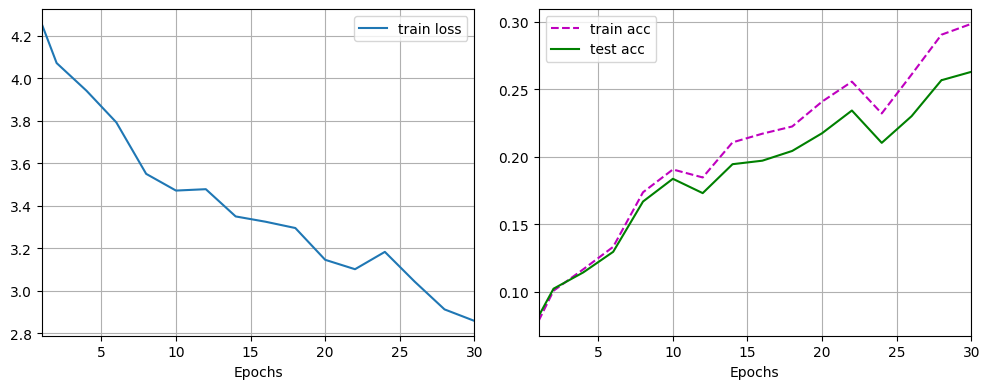

In [11]:
# 创建模型，进行训练
model = LeNet_BatchNorm(input_shape=(32,32,3),num_class=100)
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=30,verbose=2,lr=0.1)

从以上我们可以观察到：
* 即使使用了`sigmoid`激活函数，我们依然能够顺利训练神经网络，这和前面的实验是不同的
* 模型的**过拟合现象得到了缓解**

我们还可以单独拿出`BatchNorm`层的参数，查看模型学习得到的分布

In [16]:
print("BatchNorm Layer1 gamma: ",model.layers[1].gamma.numpy())
print("BatchNorm Layer1 beta: ",model.layers[1].beta.numpy())

BatchNorm Layer1 gamma:  [1.4843254 0.855892  0.8508167 0.7450152 2.3765    1.0808977]
BatchNorm Layer1 beta:  [1.7862403 0.8048541 0.9882797 0.4233838 2.7899203 1.0098336]


`BatchNorm`作为一个广泛使用的技巧，也已经加入了各个深度学习框架的API中，我们可以在`tf.keras.layers`中找到

```python
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
    **kwargs,
)
```

需要指出：
* 前面提到的有关BatchNorm有效的各种解释都只是**直觉**，目前并没有理论上的严格证明
* 在深度学习模型的学习和训练中，需要培养这种**直觉**以增加成功训练模型的可能性（即大家调侃的**炼丹师**），但一定**要区分直觉和技术理论**
* 实验发现，**BatchNorm还可以放在激活函数之后**，也同样能够提升模型表现

#### **3.3.5.2 残差网络ResNet**

随着我们设计越来越深的网络，深刻**理解“新添加的层如何提升神经网络的性能”变得至关重要**，一个合理的网络架构是最核心的，如何确保**不断增加网络的层数，深度，保证模型的学习能力不断提升，而不会相反倒退造成负面影响呢？**

假设 $\mathcal{F}$ 是我们的**神经网络函数空间**，对于所有的 $f\in\mathcal{F}$，存在一些参数集合（权重和偏置），这些参数可以通过在合适的数据集上训练获得，现在假设 $f^*$ 是我们最终想要得到的函数：
* 如果 $f^*\in\mathcal{F}$，那么我们可以轻而易举的训练得到它
* 但通常 $f^*\notin \mathcal{F}$，实际上，我们是寻找 $f_{\mathcal{F}}^*\in\mathcal{F}$ 去逼近 $f^*$

$$
f_{\mathcal{F}}^* = \mathop{\arg\min}\limits_{f} L(\boldsymbol{X},\boldsymbol{y},f),\quad f\in\mathcal{F}
$$

为了更好的逼近 $f^*$，我们应该**设计一个更强大的函数族** $\mathcal{F}'$，使得：
$$
\min_{f\in\mathcal{F}'} L(\boldsymbol{X},\boldsymbol{y},f) \leq \min_{f\in\mathcal{F}} L(\boldsymbol{X},\boldsymbol{y},f) \quad\text{或者说}\quad \|f_{\mathcal{F}'}^* - f^*\| \leq \|f_{\mathcal{F}}^* - f^*\|
$$

然而，如果 $\mathcal{F}\not\subset \mathcal{F}'$，则**无法保证在新的函数族** $\mathcal{F}'$ **中能找到更近似的极值点** $f^*$，事实上，如果 $\mathcal{F}\not\subset \mathcal{F}'$，很有**可能会出现更糟糕**的情况：
$$
\min_{f\in\mathcal{F}'} L(\boldsymbol{X},\boldsymbol{y},f) > \min_{f\in\mathcal{F}} L(\boldsymbol{X},\boldsymbol{y},f) \quad\text{或者说}\quad \|f_{\mathcal{F}'}^* - f^*\| > \|f_{\mathcal{F}}^* - f^*\|
$$

如下图所示：

<img src="./source/Chap3/嵌套函数类.svg" width=800>

* 对于**非嵌套函数类**，较复杂的函数类 $\mathcal{F}_k$ 并不总是向 $f^*$ 靠拢
  * 例如 $\mathcal{F}_3$ 比  $\mathcal{F}_1$ 更靠近 $f^*$，但 $\mathcal{F}_6$ 却更远了
* **嵌套函数类** $\mathcal{F}_1\subset \mathcal{F}_2\subset \cdots \mathcal{F}_6$ 随着复杂度的提升，可以避免上述问题

因此，只有**当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能**：
* 对于深度神经网络，如果我们能**将新添加的层训练成恒等映射** $f(x)=x$，新模型和原模型将同样有效
* 同时，**由于新模型可能得出更优的解来拟合训练数据集**，因此添加层似乎更容易降低训练误差

针对这一问题，何恺明等人提出了残差网络`ResNet`，它在2015年的ImageNet图像识别挑战赛夺魁，并**深刻影响了后来的深度神经网络的设计**，它的核心思想是，**每个附加层都应该更容易地包含原始函数作为其元素之一**

`ResNet`的核心是使用**残差跳连**技术，构建**残差块**，一个普通块和残差快的结构对比如下图所示

<img src="./source/Chap3/残差跳连.svg" width=600>

假设我们的原始输入为 $x$，希望拟合得到的理想映射为 $f(x)$：
* 左图虚线框中的部分需要直接拟合出该映射 $f(x)$
* 右图虚线框中的部分只需要拟合出残差映射 $f(x)-x$，而**残差映射在现实中往往更容易优化**
  * 在残差块中，**输入** $x$ **可通过跨层数据线路更快地向前传播**
  * 如前文提到的，假设我们想要拟合恒等映射 $f(x) = x$，**残差跳连只需要将参数和偏置全部设为 0**，而这对于左图中的模型则会困难许多
  * 当理想映射 $f(x)$ 很接近恒等映射时，**残差跳连也易于捕捉近似恒等映射的细微波动**

`ResNet`的卷积运算沿用了`VGGNet`的 $3\times 3$ 卷积：
* 残差块里首先有2个有相同输出通道数的 $3\times 3$ 卷积核，卷积运算后接 BatchNorm 和激活函数
* **通过跨层数据通路，跳过这2个卷积运算**，将输入直接加在最后的 ReLU 激活函数前
* **这样的设计要求 2 个卷积层的输出与输入形状一样**，从而使得它们可以相加
* **如果想改变通道数**，就需要**引入一个额外的** $1\times 1$ **卷积层**来将输入变换成需要的形状后再做相加运算

<img src="./source/Chap3/Residual块.svg" width=700>

In [11]:
class Residual(tf.keras.Model):
    def __init__(self, num_channels, strides : int=1, use_1x1conv : bool=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 卷积层
        self.conv1 = tf.keras.layers.Conv2D(num_channels,kernel_size=3,padding="same",strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels,kernel_size=3,padding="same")
        # 是否使用 1x1 卷积核来调整通道数和分辨率
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels,kernel_size=1,strides=strides)
        else:
            self.conv3 = None
        # BatchNorm层
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
    
    def call(self, inputs, training=None, mask=None):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(inputs)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            inputs = self.conv3(inputs)
        # 残差跳连
        Y += inputs 
        return tf.keras.activations.relu(Y)

下面我们来查看输入和输出形状一致的情况

In [12]:
blk = Residual(num_channels=3)
# 批量大小为 5，高宽为6， 通道数为 3 的输入
X = tf.random.uniform((5, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([5, 6, 6, 3])

我们也可以在**增加输出通道数的同时，减半输出的高和宽**

In [14]:
# strides = 2 可以减半高宽
# use_1x1conv = True 对输入做一次变换，确保可以进行残差跳连
blk = Residual(num_channels=6,strides=2,use_1x1conv=True)
# 批量大小为 5，高宽为6， 通道数为 3 的输入
X = tf.random.uniform((5, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([5, 3, 3, 6])

最后，我们来搭建`ResNet`模型，ResNet的前两层跟之前介绍的GoogLeNet中的一样，在输出通道数为 64、步幅为2的 $7\times 7$ 卷积层后，接步幅为2的 $3\times 3$ 的最大汇聚层。 不同之处在于ResNet每个卷积层后增加了批量规范化层

In [16]:
def ResNetBlock1():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])

**GoogLeNet在后面接了4个由Inception块组成的模块**，**ResNet则使用4个由残差块组成的模块**，每个模块使用若干个同样输出通道数的残差块

In [17]:
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels : int, num_residuals : int, first_block=False, 
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))
    
    def call(self, inputs, *args, **kwargs):
        for layer in self.residual_layers:
            inputs = layer(inputs)
        return inputs

最后，**与GoogLeNet和NiN一样，在ResNet中加入全局平均汇聚层，以及全连接层输出**，为了后续演示方便，我们仍然将图像规模设定为 $96\times 96$

In [21]:
def ResNet(input_shape : tuple, num_class : int):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(input_shape),
        tf.keras.layers.experimental.preprocessing.Resizing(width=96,height=96),
        # 第一层
        ResNetBlock1(),
        # 后续四层残差块
        ResNetBlock(num_channels=64,num_residuals=2,first_block=True),
        ResNetBlock(num_channels=128,num_residuals=2),
        ResNetBlock(num_channels=256,num_residuals=2),
        ResNetBlock(num_channels=512,num_residuals=2),
        # 全剧平均池化，得到输出概率
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_class),
        tf.keras.layers.Softmax()
    ])

每个模块有4个卷积层（不包括恒等映射的 $1\times 1$ 卷积层），加上第一个 $7\times 7$ 卷积层和最后一个全连接层，共有18层，因此，这种模型通常被称为 `ResNet-18`，通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如**更深的含152层的** `ResNet-152`

In [25]:
model = ResNet(input_shape=(32,32,3),num_class=100)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 24, 24, 64)        9728      
                                                                 
 res_net_block_8 (ResNetBloc  (None, 24, 24, 64)       148736    
 k)                                                              
                                                                 
 res_net_block_9 (ResNetBloc  (None, 12, 12, 128)      526976    
 k)                                                              
                                                                 
 res_net_block_10 (ResNetBlo  (None, 6, 6, 256)        2102528   
 ck)                                                             
                                                      

`ResNet-18` 有**大约1100万的可训练参数**

In [23]:
# 加载 CIFAR-100 数据集
(x_train,y_train), (x_test,y_test) = ch3.load_cifar100()

训练集特征形状： (50000, 32, 32, 3)
训练集标签形状： (50000, 1)


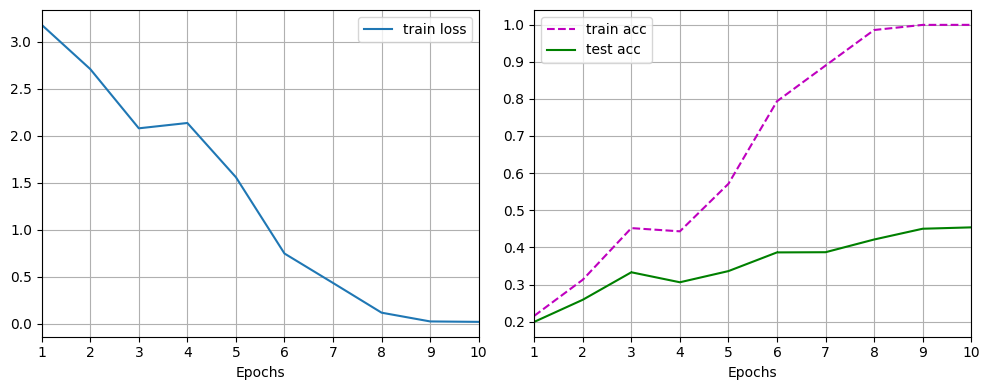

In [26]:
# 进行训练
model = ch3.train(model,train_tensors=(x_train,y_train),test_tensors=(x_test,y_test),
                  batch_size=128,epochs=10,verbose=1,lr=0.05)

从图中，我们可以看到：
* `ResNet`相比其他深度模型**非常夸张的收敛速度**，仅仅10次迭代，模型就在训练集上取得100%的正确率
* `ResNet`依然出现了深度模型常见的**过拟合问题**，我们需要**更强的正则化手段**

### **3.3.6 稠密连接网络DenseNet**

ResNet极大地改变了如何参数化深层网络中函数的观点，除了残差跳连外，`DenseNet` 给出了另一种扩充函数族的方法

回想任意函数的泰勒展开式，它将这个函数分解成越来越高阶的项：
$$
f(x) = f(0) + f'(0)x + \frac{f''(0)}{2!}x^2 + \frac{f'''(0)}{3!}x^3 + \cdots
$$

而 ResNet 将函数展开为：
$$
f(x) = x + g(x),\quad g(x)\to f(x) - x
$$

ResNet将 $f$ 分解为两部分，**一个简单的线性项和一个复杂的非线性项**，如果我们想将 $f$ **拓展成超过两部分的信息**，DenseNet就是其中的一种解决方案

<img src="./source/Chap3/DenseNet块.svg" width=300>

**ResNet和DenseNet的关键区别在于，DenseNet输出是拼接**，图中的 $[,]$运算，而不是 ResNet 的简单相加，因此，在应用越来越复杂的函数序列后，我们执行从 $x$ 到其展开式的映射：
$$
x\to \left[ x, f_1(x), f_2([x,f_1(x)]), f_3([x, f_1(x), f_2([x,f_1(x)])]),\cdots \right]
$$

最后，**将这些展开式结合到多层感知机中，再次减少特征的数量**。 实现起来非常简单，结构如下图所示：

<img src="./source/Chap3/稠密连接.svg" width=500>

稠密网络`DenseNet`主要由2部分构成：
* **稠密块**（dense block）：定义如何连接输入和输出
* **过渡层**（transition layer）：控制通道数量，使其不会太复杂

我们将在练习的部分引导完成`DenseNet`模型的编写和训练

----

### **练习**

1. 按下面的提示搭建`DenseNet`
   1. `DenseNet` 以卷积块 `ConvBlock` 作为基础单元，请继承 `tf.keras.layers.Layer` 定义 `ConvBlock`，每个卷积块**按顺序包含三个操作**：BatchNorm，ReLU激活函数，$3\times 3$ 卷积层，卷积层使用填充，可以通过`__init__`方法控制卷积层输出的通道数量`num_channels`
      1. 假设输入 $X\in\mathbb{R}^{N\times W\times H\times c}$，经过上述三个运算后的输出 $Y\in\mathbb{R}^{N\times W\times H\times d}$，`ConvBlock` 还需要**按照稠密网络的思想，将输入和输出拼接在一起**，拼接使用`tf.concat`实现，并且需要**在通道维度上进行拼接**，因此最终输出维度是 $[X,Y]\in\mathbb{R}^{N\times W\times H\times (c+d)}$
      ```python
      class ConvBlock(tf.keras.layers.Layer):
         def __init__(self, num_channels : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
            """
            num_channels : int
               卷积层的输出通道数量
            """
            super().__init__(trainable, name, dtype, dynamic, **kwargs)
            ...
         
         def call(self, inputs, *args, **kwargs):
            ...
      ```
   2. 每个稠密快 `DenseBlock` 由多个卷积块 `ConvBlock` 组成，**每个卷积块使用相同数量的输出通道**，在前向推理中，我们将每个卷积块的输入和输出在通道维上连结，请继承  `tf.keras.layers.Layer` 定义 `DenseBlock`，可以通过`__init__`方法控制卷积块的数量`num_convs`
      ```python
      class DenseBlock(tf.keras.layers.Layer):
         def __init__(self, num_convs : int, num_channels : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
            """
            num_convs : int
               该稠密块包含的卷积块的数量
            num_channels : int
               每个卷积块的输出通道的数量
            """
            super().__init__(trainable, name, dtype, dynamic, **kwargs)
            ...
         
         def call(self, inputs, *args, **kwargs):
            ...
      ```
   3. 生成一个随机输入 $X\in\mathbb{R}^{4\times 8\times 8\times 3}$，定义一个拥有两个卷积块（`num_convs = 2`），卷积块输出通道数量为10（`num_channels = 10`）的 `DenseBlock` 实例，检验计算结果，模型的输出维度应该是 $4\times 8\times 8\times 23$
   4. 由于每个稠密块都会带来通道数的增加，使用过多会让模型太复杂，定义过渡层 `TransitionBlock` 控制模型复杂度，请继承  `tf.keras.layers.Layer` 定义 `TransitionBlock`：
      1. 先进行 BatchNorm 和 ReLU 激活
      2. 通过 $1\times 1$ 卷积层来减小通道数，通道数`num_channels`可以通过`__init__`方法控制
      3. 使用尺寸为2，步幅为2的平均汇聚层减半高和宽，进一步降低模型复杂度
      ```python
      class TransitionBlock(tf.keras.layers.Layer):
         def __init__(self, num_channels : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
            """
            num_channels : int
               控制过渡层的输出通道数量
            """
            super().__init__(trainable, name, dtype, dynamic, **kwargs)
            ...
         
         def call(self, inputs, *args, **kwargs):
            ...
      ```
   5. 接下来，我们定义 `DenseNet` 模型，你可以尝试用`tf.keras.models.Sequential`或者其他你喜欢的方法实现
      1. 模型第一块与 `ResNet` 相同，使用单卷积层和最大汇聚层，计算过程如下
         1. 使用尺寸为7，步幅为2，输出通道为64的卷积核，启用填充
         2. 进行 BatchNorm 和 ReLU 激活
         3. 使用尺寸为3，步幅为2的最大汇聚层，启用填充
      2. 模型第二块同样与 `ResNet` 类似，`ResNet` 使用四个残差块，`DenseNet` 使用**四个稠密快**
         1. 总共四个 `DenseBlock`，每个均设置 `num_convs = 4` 包含四个卷积块，通道数 `num_channels = 32`
         2. 请问，经过每个 `DenseBlock` 后，特征的通道数量增加多少个？
         3. 在四个  `DenseBlock` **两两之间添加三个过渡层** `TransitionBlock`，**每个过渡层负责将当前的通道数减半**
      3. 最后到分类器的部分，对最后一个 `DenseBlock` 的输出执行如下变换：
         1. 首先 BatchNorm 和 ReLU 激活
         2. 使用全局平均池化，并将特征拉直为向量
         3. 根据分类问题的类别数，设定最后的全连接层
         4. 连接`Softmax()`激活，将输出变为概率分布
   6. 选择训练模型的合适超参数，测试模型在`CIFAR-100`上的表现

2. 该练习帮助你**理解卷积神经网络的特征提取功能**
   1. 选择一个你喜欢的网络结构，例如 `LeNet`，用 `tf.keras.models.Sequential` 方法实现它
      * **确保可以获得模型中间部分卷积层的计算结果**，对于 `Sequential` 模型，`model.layers` 可以访问每一层计算曾
   2. 让模型在 `Fashion-MNIST` 数据集上训练，确保模型收敛
   3. 绘制不同输入（例如毛衣和鞋子）时，网络不同卷积块层，各个通道的计算结果
      * 如果你选择的是 `LeNet`，就绘制第一层卷积和第二层卷积的输出
   4. 如果上述实现有困难，或者想更直观地理解卷积神经网络，可以访问![https://poloclub.github.io/cnn-explainer/]

**提示**：假设你已经创建了 `Sequential` 模型实例 `model`，从输入到输出共包含 $N$ 个计算层，如果你想获得它第 $k < N$ 层的输出结果，可以按如下方式再创建一个序列模型：
```python
# 你定义的序列模型
model = ... 

# 确定你想要获取的中间层层数 k
k = 5
k_layers_model = tf.keras.models.Sequential(
    model.layers[0:k] # layers 是一个 list
)

# 给定输入，计算第 k 层的输出
X = ...
k_layers_outputs = k_layers_model(X)
```